# Adam Optimizer  - Adaptive Moment Estimation 
* The unique aspect of Adam is that the update to each parameter is scaled individually. The amount by which each parameter is adjusted is influenced by both the first moment (capturing the momentum of the gradients) and the second moment (reflecting the variability of the gradients). This adaptive adjustment leads to more efficient and effective optimization, especially in complex models with many parameters.

* The small constant ϵ is added to prevent any issues with division by zero, which is especially important when the second moment estimate v^t​ is very small. This addition is a standard practice in numerical algorithms to ensure stability.

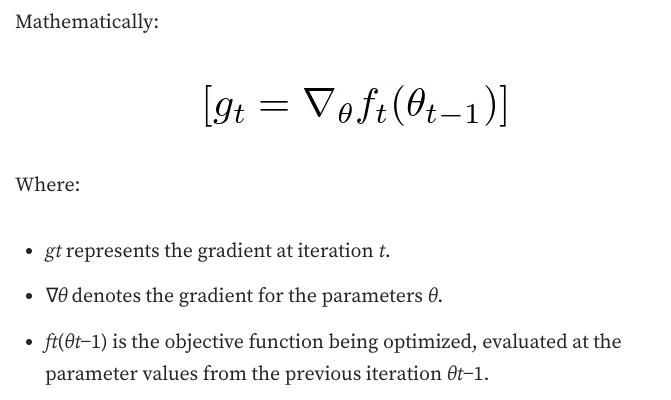
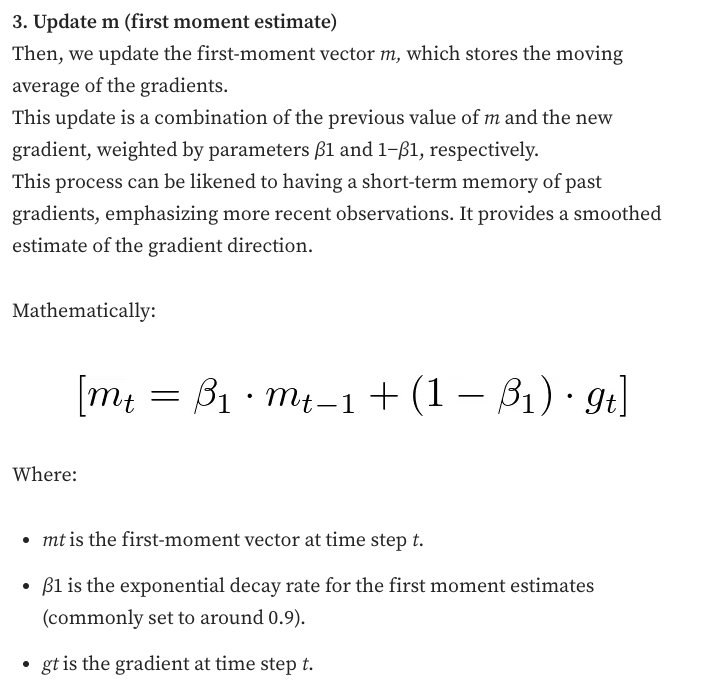
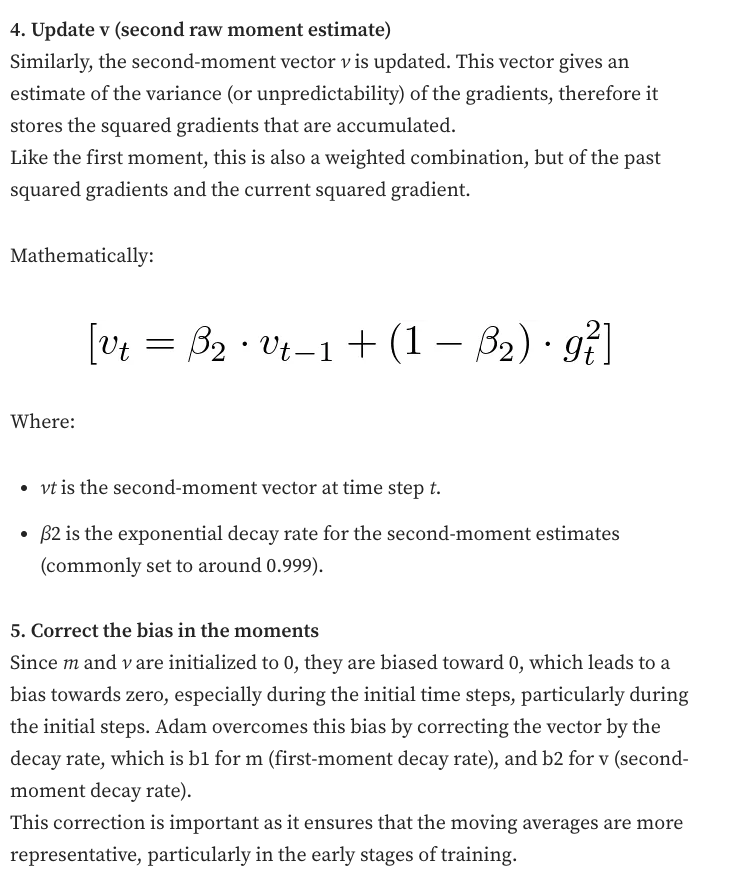
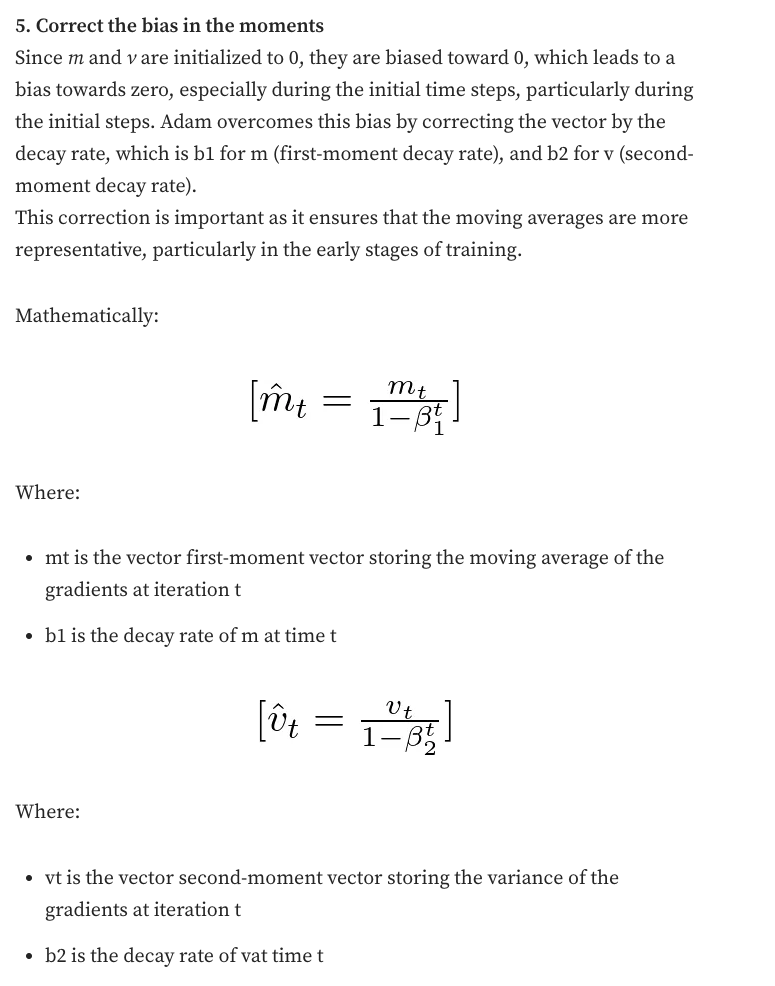
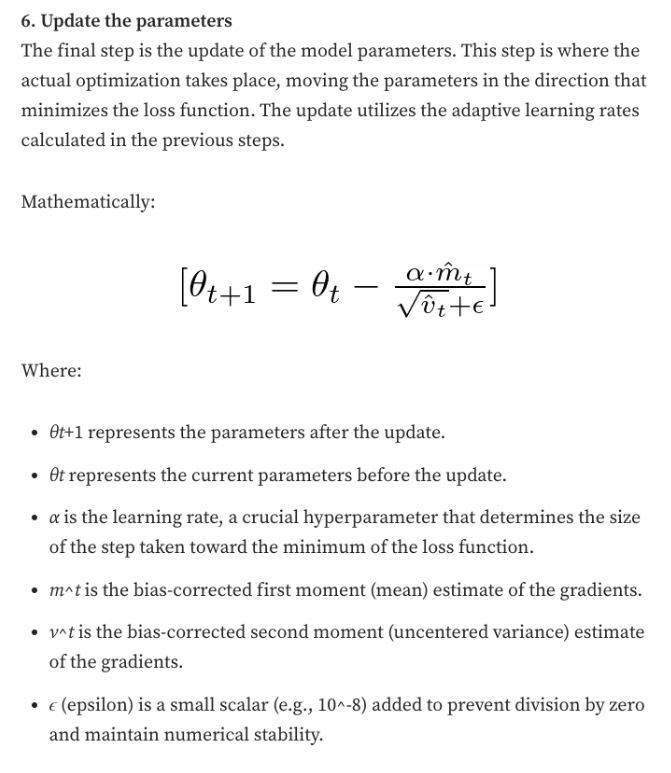
*Source: https://medium.com/towards-data-science/the-math-behind-adam-optimizer-c41407efe59b*

In [1]:
import numpy as np

In [21]:
class AdamOptimizer:
    def __init__(self, learning_rate:float=0.001, beta1:float=0.9, beta2:float=0.999, epsilon:float=1e-8) -> None:
        """
        Constructor for the AdamOptimizer class.
        
        Parameters:
        ---------------
        learning_rate  - Learning rate for the optimizer
        beta1          - Exponential decay rate for the first moment estimates
        beta2          - Exponential decay rate for the second moment estimates
        epsilon        - Small value to prevent division by zero
        
        Returns
        ---------------
        None
        """
        self.learning_rate = learning_rate
        self.beta1         = beta1
        self.beta2         = beta2
        self.epsilon       = epsilon
        self.m             = None
        self.v             = None
        self.t             = 0
        
    def initialize_moments(self, params:dict) -> None:
        """
        Initializes the first and second moment estimates.
        Parameters:
        ---------------
        params         - Dictionary containing the mdoel parameters
        
        Returns
        ---------------
        None
        """
        self.m = {k: np.zeros_like(v) for k, v in params.items()}
        self.v = {k: np.zeros_like(v) for k, v in params.items()}
        
    def updated_params(self, params:dict, grads:dict) -> dict:
        """
        Updates the model parameters using the Adam optimizer.
        
        Parameters
        ---------------
        params         - Dictionary containing the mdoel parameters
        grads          - Dictionary containing the gradients for each parameter

        
        Returns
        ---------------
        updated_params - Dictionary containing the updated model parameters.
        """
        if self.m is None or self.v is None:
            self.initialize_moments(params)
            
        self.t += 1
        updated_params = {}
        
        for key in params.keys():
            self.m[key] = self.beta1 * self.m[key] + (1 - self.beta1) * grads[key]
            self.v[key] = self.beta2 * self.v[key] + (1 - self.beta2) * np.square(grads[key])
            
            m_corrected = self.m[key] / (1 - self.beta1 ** self.t)
            v_corrected = self.v[key] / (1 - self.beta2 ** self.t)
            
            updated_params[key] = params[key] - (self.learning_rate * m_corrected) / (np.sqrt(v_corrected) + self.epsilon)
            
        return updated_params
            
        

In [22]:
class LinearRegression:
    def __init__(self, n_features: int) -> None:
        """
        Constructor for the LinearRegression class.
        Parameters:
        -----------------
        n_features      - Number of features in the input data.
        
        Returns
        -----------------
        None
        """
        self.weights = np.random.randn(n_features)
        self.bias    = np.random.randn()
        
    def predict(self, X:np.array) -> np.array:
        """
        Parameters
        -----------------
        X              - Input Data
        
        Returns
        -----------------
        Predictions
        """
        return np.dot(X, self.weights) + self.bias

In [23]:
class ModelTrainer:
    def __init__(self, model:object, optimizer:object, n_epochs:int) -> None:
        """
        Constructor for the ModelTrainer class.

        Parameters
        ----------
        model            - Model to be trained.
        optimizer        - Optimizer to be used for training.
        n_epochs         - Number of training epochs.

        Returns
        -------
        None.
        """
        self.model     = model
        self.optimizer = optimizer
        self.n_epochs  = n_epochs 
    
    def compute_gradients(self, X:np.array, y:np.array) -> dict:
        """
        Computes the gradients of the mean squared error loss function
        with respect to the model parameters.

        Parameters
        ----------
        X - Input data.
        y - Target variable.
        
        Returns
        -------
        Dictionary containing the gradients for each parameter.
        """
        predictions = self.model.predict(X)
        errors = predictions - y
        dW = 2 * np.dot(X.T, errors) / len(y)
        db = 2 * np.mean(errors)
        return {'weights': dW, 'bias': db}
    
    def train(self, X:np.array, y:np.array, verbose:bool=False) -> None:
        """
        Runs the training loop, updating the model parameters and optionally printing the loss.

        Parameters
        ----------
        X - Input data.
        y - Target variable.
        
        Returns
        -------
        None
        """
        for epoch in range(self.n_epochs):
            grads = self.compute_gradients(X, y)
            params = {'weights': self.model.weights, 'bias': self.model.bias}
            updated_params = self.optimizer.updated_params(params, grads)
            
            self.model.weights = updated_params['weights']
            self.model.bias = updated_params['bias']
            
            loss = np.mean((self.model.predict(X) - y)**2)
            if epoch % 1000 == 0 and verbose:
                print(f"Epoch {epoch}, Loss: {loss}")

In [24]:
# Basic Libraries
import pandas as pd

# Load Data
from sklearn.datasets import load_diabetes

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model Fine Tuning
import optuna

# Filter Warnings
import warnings
warnings.filterwarnings('ignore')

In [25]:
# Load the diabetes dataset
diabetes = load_diabetes()
df = pd.DataFrame(data=diabetes.data, columns=diabetes.feature_names)
df['target'] = diabetes.target
df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


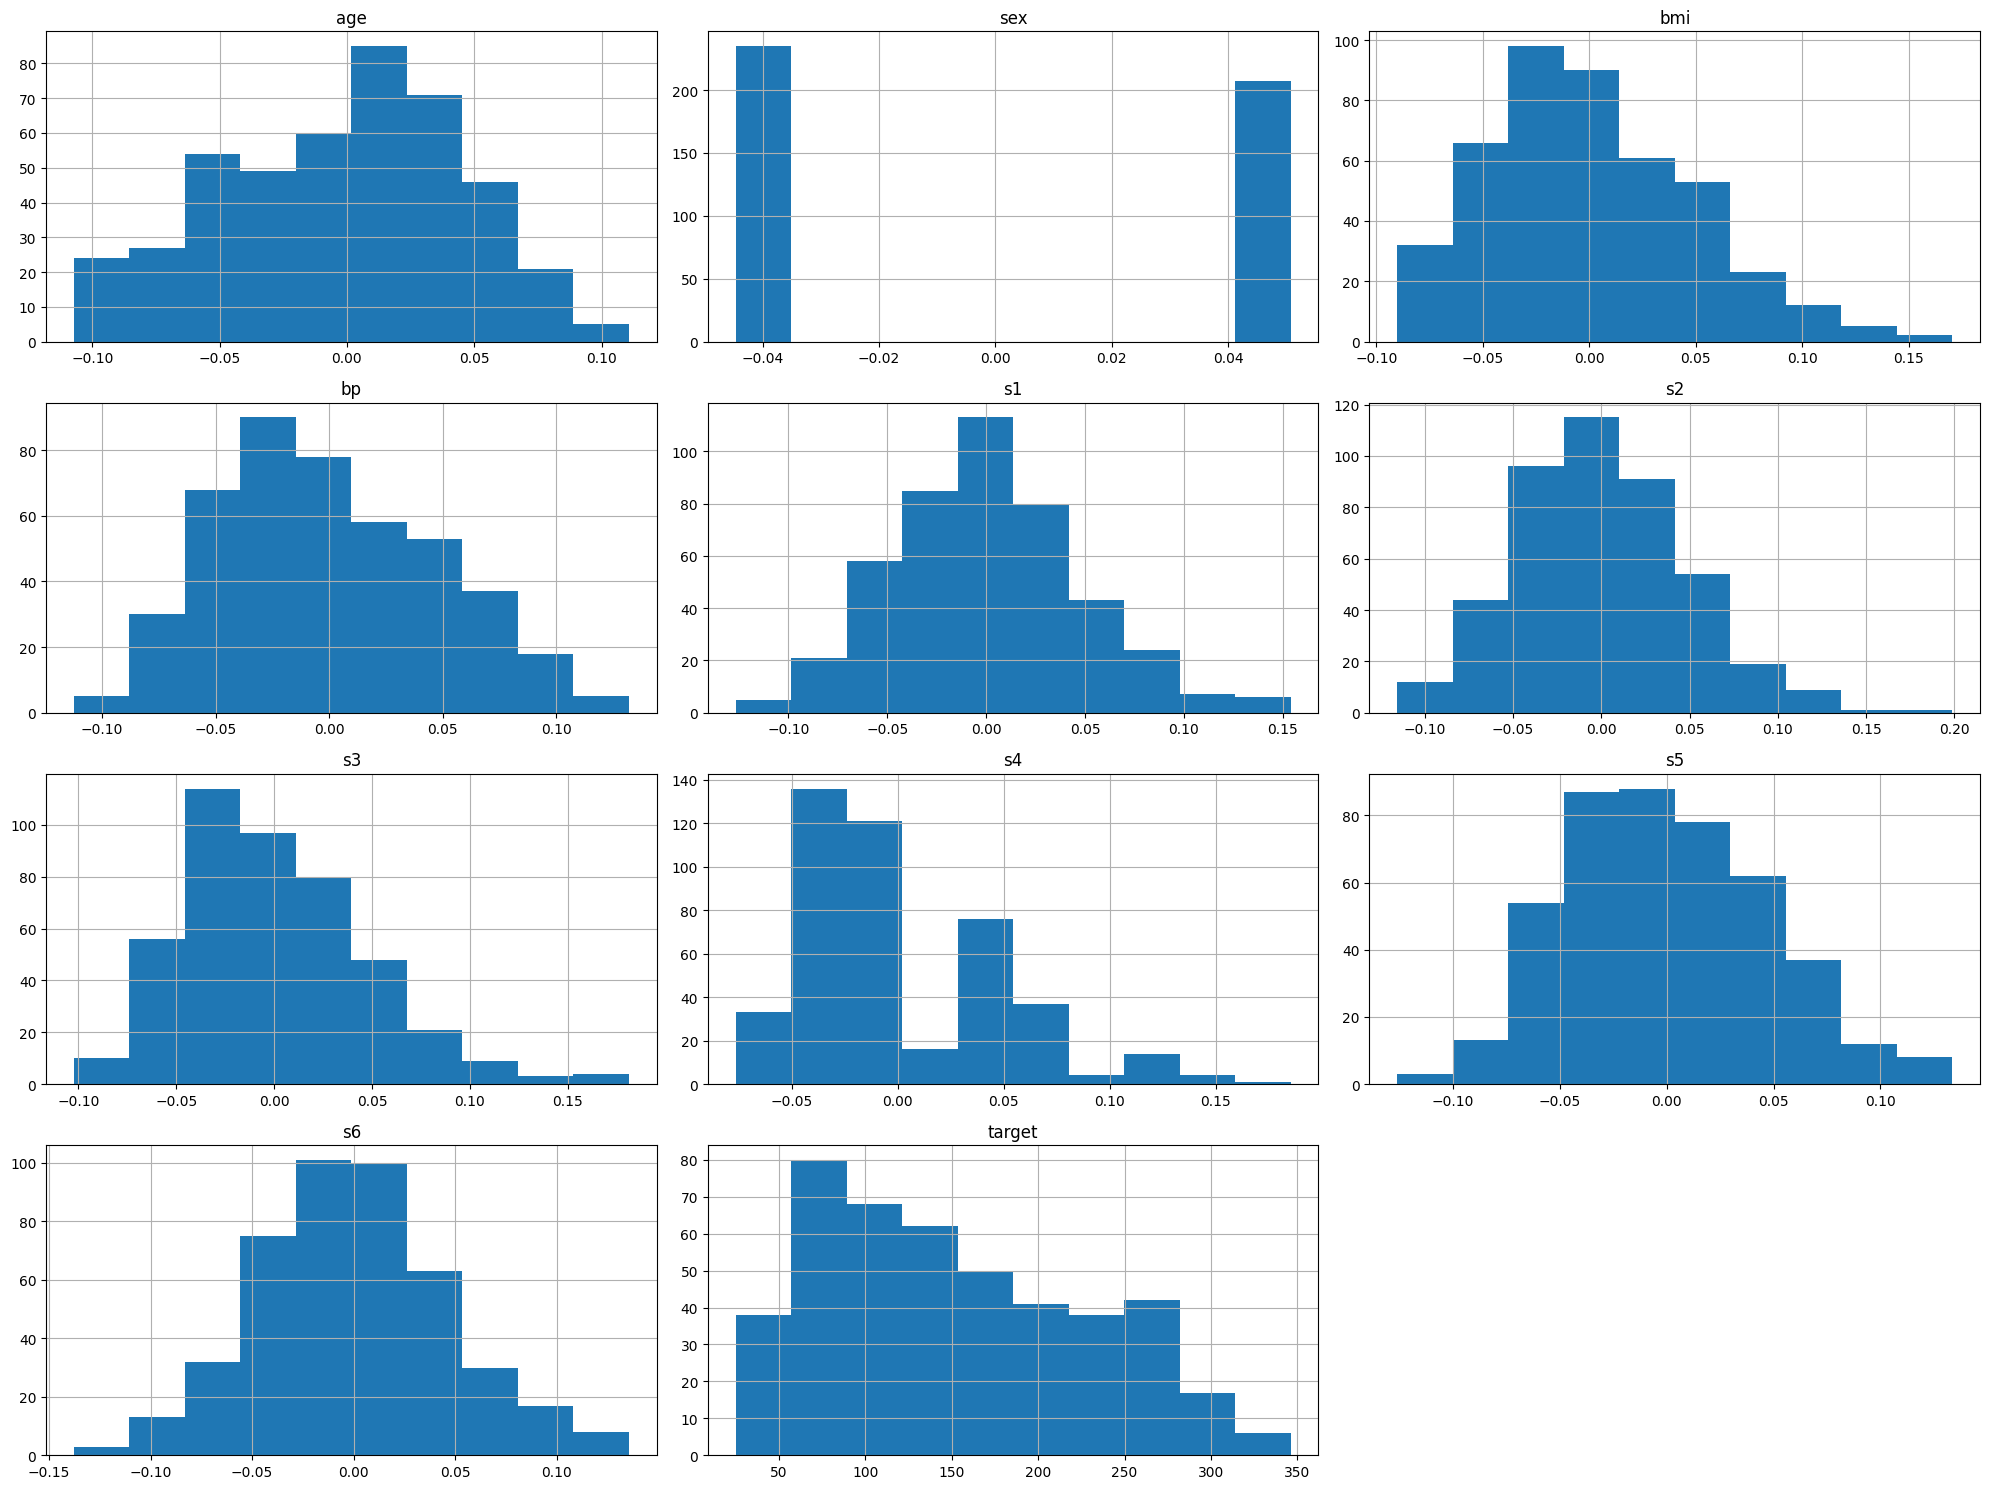

In [26]:
# Create histograms for each feature
df.hist(bins=10, figsize=(20, 15))
plt.tight_layout()
plt.show()

In [27]:
# Get the input features (X) and target values (y)
X = diabetes.data
y = diabetes.target

# Split the dataset into training and test sets
def split_dataset(X, y, test_ratio=0.2):
    indices = np.random.permutation(len(X))
    test_size = int(len(X) * test_ratio)
    test_indices = indices[:test_size]
    train_indices = indices[test_size:]
    return X[train_indices], X[test_indices], y[train_indices], y[test_indices]

X_train, X_test, y_train, y_test = split_dataset(X, y)
X_train, X_val, y_train, y_val = split_dataset(X_train, y_train)

In [28]:
def objective(trial):
    n_features = X_train.shape[1]

    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    beta1 = trial.suggest_uniform('beta1', 0.9, 0.999)
    beta2 = trial.suggest_uniform('beta2', 0.99, 0.9999)
    epsilon = trial.suggest_loguniform('epsilon', 1e-10, 1e-5)

    n_epochs = trial.suggest_int('epochs', 1000, 100000)

    # Define the model
    model = LinearRegression(n_features)
    optimizer = AdamOptimizer(learning_rate=learning_rate, beta1=beta1, beta2=beta2, epsilon=epsilon)
    trainer = ModelTrainer(model, optimizer, n_epochs=n_epochs)

    # Train the model
    trainer.train(X_train, y_train, verbose=False)

    # Compute the validation loss
    val_loss = np.mean((model.predict(X_val) - y_val) ** 2)

    return val_loss

# Create the study object
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))

# Optimize the study, use more trials to obtain better results, use less trials to be more cost-efficient
study.optimize(objective, n_trials=10)

In [29]:
# Print optimization results
print("---------------------------------------")
print('Number of finished trials:', len(study.trials))
print('Best trial:')
for key, value in study.best_trial.params.items():
    if key == 'epochs' or key == 'epsilon':
        print(f'    {key}: {value}')
    else:
        print(f'    {key}: {value:.3f}')

---------------------------------------
Number of finished trials: 10
Best trial:
    learning_rate: 0.003
    beta1: 0.917
    beta2: 0.991
    epsilon: 5.5517216852447175e-06
    epochs: 96598


In [30]:
# Get the best model
n_features = X_train.shape[1]
best_model = LinearRegression(n_features)
optimizer = AdamOptimizer(learning_rate=study.best_params['learning_rate'],
                          beta1=study.best_params['beta1'],
                          beta2=study.best_params['beta2'],
                          epsilon=study.best_params['epsilon'])

# Train the model
trainer = ModelTrainer(best_model, optimizer, n_epochs=study.best_params['epochs'])
trainer.train(X_train, y_train)

# Compute the test loss
test_loss = np.mean((best_model.predict(X_test) - y_test) ** 2)**0.5
print(f'Test loss: {test_loss:.2f}')

Test loss: 59.99


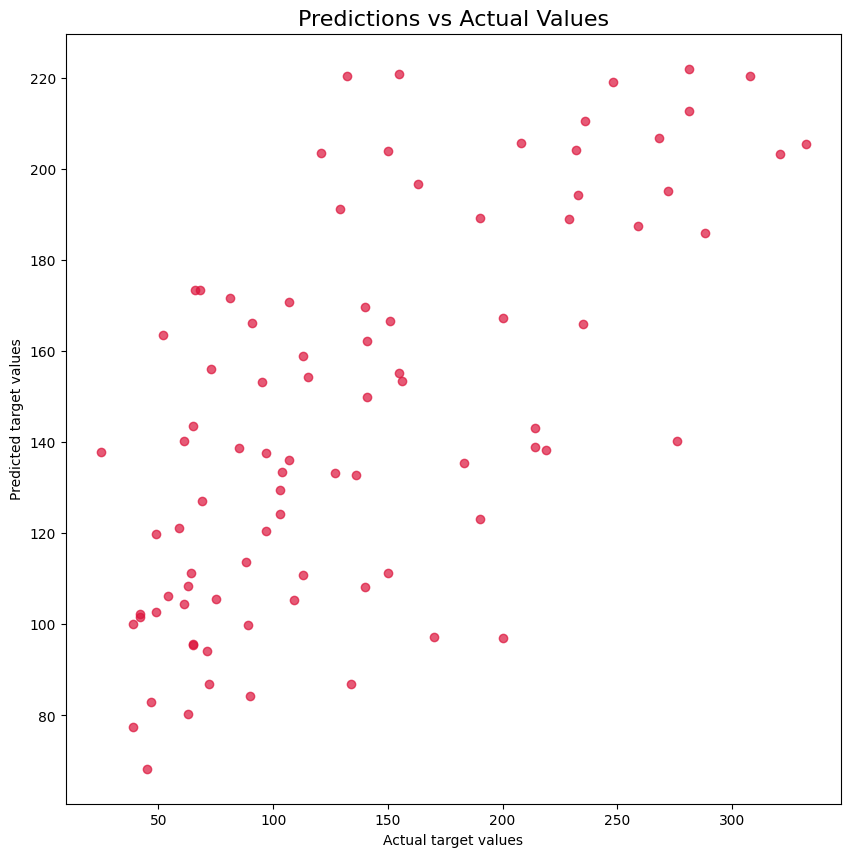

In [31]:
# Plot the predictions vs the actual values
plt.figure(figsize=(10, 10))
plt.scatter(y_test, best_model.predict(X_test), c='crimson', alpha=0.7)
plt.title('Predictions vs Actual Values', fontsize=16)
plt.xlabel('Actual target values')
plt.ylabel('Predicted target values')
plt.show()


In [32]:
import tensorflow as tf
import numpy as np

# Generate Sample Data
# For demonstration, we create synthetic data for a regression task
X = np.random.rand(100, 3)  # 100 samples, 3 features
y = X @ np.array([2.0, -1.0, 3.0]) + 1.5  # Linear relationship with some coefficients and bias

# Create the Neural Network
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(3,)),  # Input layer with 3 inputs
    tf.keras.layers.Dense(64, activation='relu'),  # Another dense layer
    tf.keras.layers.Dense(1)  # Output layer with 1 unit (for regression)
])

# Compile the Model with the Adam Optimizer
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='mean_squared_error')  # MSE is typical for regression

# Train the Model
model.fit(X, y, epochs=10)  # Train for 10 epochs as an example

Epoch 1/10
4/4 [==============================] - 0s 1ms/step - loss: 11.9451
Epoch 2/10
4/4 [==============================] - 0s 598us/step - loss: 10.7500
Epoch 3/10
4/4 [==============================] - 0s 562us/step - loss: 9.6640
Epoch 4/10
4/4 [==============================] - 0s 588us/step - loss: 8.6387
Epoch 5/10
4/4 [==============================] - 0s 656us/step - loss: 7.6180
Epoch 6/10
4/4 [==============================] - 0s 530us/step - loss: 6.6282
Epoch 7/10
4/4 [==============================] - 0s 572us/step - loss: 5.6155
Epoch 8/10
4/4 [==============================] - 0s 596us/step - loss: 4.6846
Epoch 9/10
4/4 [==============================] - 0s 580us/step - loss: 3.7715
Epoch 10/10
4/4 [==============================] - 0s 650us/step - loss: 2.9417
